In [1]:
import numpy as np
import matplotlib.pyplot as plt
%matplotlib inline
import time
import cv2
import random

#from image import ImageDataGenerator
import os

from keras.callbacks import ModelCheckpoint
from keras.models import Sequential
from keras.layers.recurrent import SimpleRNN, LSTM, GRU
from keras.optimizers import RMSprop, Adadelta
from keras.layers.convolutional import Convolution2D,MaxPooling2D
from keras.layers.core import Dense, Activation, TimeDistributedDense, Dropout, Reshape, Flatten
from keras.layers.wrappers import TimeDistributed
from keras.models import model_from_json

# get package versions
def get_version(*vars):
    for var in vars:
        module = __import__(var)    
        print '%s: %s' %(var,module.__version__)
    
# package version    
get_version('keras','numpy','matplotlib','cv2')

Using Theano backend.


keras: 1.1.1
numpy: 1.11.2
matplotlib: 1.5.1
cv2: 3.1.0


Using gpu device 0: GeForce GTX TITAN X (CNMeM is disabled, cuDNN 5005)


## Setting

In [2]:
# path to data
path2numpy = "./output/data/numpy/"
working_path = path2numpy

h,w=512,512
experiment='unet_hw_'+str(h)+'by'+str(w)
print 'experiment:', experiment

seed = 2017
np.random.seed=seed

smooth = 1.

experiment: unet_hw_512by512


In [3]:
def grays_to_RGB(img):
    # turn 2D grayscale image into grayscale RGB
    return np.dstack((img, img, img))

def image_with_mask(img, mask):
    maximg=np.max(img)
    mask=np.asarray(mask,dtype='uint8')
    if np.max(mask)<=1:
        mask=mask*255
    # returns a copy of the image with edges of the mask added in red
    img_color = grays_to_RGB(img)
    mask_edges = cv2.Canny(mask, 100, 200) > 0
    #print np.sum(mask_edges)
    img_color[mask_edges, 0] = maximg  # set channel 0 to bright red, green & blue channels to 0
    img_color[mask_edges, 1] = 0
    img_color[mask_edges, 2] = 0
    img_color=img_color/float(np.max(img))
    return img_color

# 5D array image display
def disp_img_mask_5d(img,mask=None,ind=None):
    # img and mask are 5d arrays, N*time*C*H*W
    #img=np.squeeze(img)
    
    # check for random dispaly or based on input
    if ind is None:
        n1=np.random.randint(img.shape[0])
    else:
        n1=ind

    I1=img[n1]
    print I1.shape
    
    if mask is None:
        M1=np.zeros(I1.shape,dtype='uint8')
    else:
        mask=np.squeeze(mask)
        M1=mask[n1,:]
    print M1.shape
    
    r,c=2,5
    for k in range(r*c):
        plt.subplot(r,c,k+1)
        imgmask=image_with_mask(I1[k,:],M1[k,:])
        plt.imshow(imgmask)
        plt.title('s: %s, maxI: %s' %(n1,np.max(I1[k,:])))
    plt.show()

# sample
def disp_img_mask(img,mask=None,r=1,c=1,shuffle=False,d=0):
    if mask is None:
        mask=np.zeros_like(img)
    
    N=np.min([r*c,img.shape[0]])
    if d==2:
        img=np.transpose(img,(2,0,1))
        img=np.expand_dims(img,axis=1)
        mask=np.transpose(mask,(2,0,1))
        mask=np.expand_dims(mask,axis=1)
    
    if len(img.shape)==3:
        img=np.expand_dims(img,axis=1)
        mask=np.expand_dims(mask,axis=1)

        
    if shuffle is True:
        n1=np.random.randint(img.shape[0],size=N)
    else:
        n1=range(0,N)
    
    #if d==0:    
    I1=img[n1,0]
    #M1=mask[n1,0]
    M1=np.zeros(I1.shape,dtype='uint8')
    for c1 in range(mask.shape[1]):
        M1=np.logical_or(M1,mask[n1,c1,:])    
    for k in range(N):    
        imgmask=image_with_mask(I1[k],M1[k])
        plt.subplot(r,c,k+1)
        plt.imshow(imgmask)
        plt.title(n1[k])
    return n1        
    
    
# preprocess
def preprocess(X,Y,param_prep):
    # X,Y: n,c,h,w
    N,C,H,W=X.shape
    
    # get params
    h=param_prep['h']
    w=param_prep['w']    
    crop=param_prep['crop']
    norm_type=param_prep['norm_type'] # normalization 
    
    
    # center crop h*w
    if crop is 'center':
        hc=(H-h)/2
        wc=(W-w)/2
        X=X[:,:,hc:H-hc,wc:W-wc]
        Y=Y[:,:,hc:H-hc,wc:W-wc]
    elif crop is 'random':
        hc=(H-h)/2
        wc=(W-w)/2
        hcr=np.random.randint(hc)
        wcr=np.random.randint(wc)
        X=X[:,:,hc:H-hc,wc:W-wc]
        Y=Y[:,:,hc:H-hc,wc:W-wc]
        
    # check if need to downsample
    # resize if needed
    if h<H:
        X_r=np.zeros([N,C,h,w],dtype=X.dtype)
        Y_r=np.zeros([N,C,h,w],dtype=Y.dtype)
        for k1 in range(X.shape[0]):
            X_r[k1] = cv2.resize(X[k1,0], (w, h), interpolation=cv2.INTER_CUBIC)
            Y_r[k1] = cv2.resize(Y[k1,0], (w, h), interpolation=cv2.INTER_CUBIC)
    else:
        X_r=X
        Y_r=Y
    
    # normalization
    X_r=np.array(X_r,dtype='float32')
    if norm_type is 'global':
        X_r-=np.mean(X_r)
        X_r/=np.std(X_r)
    elif norm_type is 'local':
        for k in range(X_r.shape[0]):
            mean = np.mean(X_r[k,0])  # mean       
            sigma = np.std(X_r[k,0])  # std
            if sigma<1e-5:
                sigma=1
            X_r[k] = X_r[k]-mean
            X_r[k] = X_r[k]/ sigma
    elif norm_type is 'scale':
        X_r-=np.min(X_r)
        X_r/=np.max(X_r)
            
    return X_r,Y_r


def array_stats(*args):
    for X in args:
        X=np.asarray(X)
        print 'array shape: ',X.shape, X.dtype
        #print 'min: %.3f, max:%.3f, avg: %.3f, std:%.3f' %(np.min(X),np.max(X),np.mean(X),np.std(X))
        print 'min: {}, max: {}, avg: {:.3}, std:{:.3}'.format( np.min(X),np.max(X),np.mean(X),np.std(X))


        
# functions
from keras.layers import Input, merge, Convolution2D, MaxPooling2D, UpSampling2D,Dropout,AtrousConvolution2D
from keras.layers import Activation,Reshape,Permute,Flatten,Dense
from keras.layers.advanced_activations import ELU
from keras.utils import np_utils
from keras.models import Model
from keras import backend as K
from keras.optimizers import Adam, SGD
from keras.models import Sequential
#from funcs.image import ImageDataGenerator


def dice_coef(y_true, y_pred):
    smooth=1
    y_true_f = K.batch_flatten(y_true)
    y_pred_f = K.batch_flatten(y_pred)
    intersection = 2. * K.sum(y_true_f * y_pred_f, axis=1, keepdims=True) + smooth
    union = K.sum(y_true_f, axis=1, keepdims=True) + K.sum(y_pred_f, axis=1, keepdims=True) + smooth
    return K.mean(intersection / union)

def dice_coef_loss(y_true, y_pred):
    return -dice_coef(y_true, y_pred)


# model
def model(params):

    h=params['img_rows']
    w=params['img_cols']
    lr=params['learning_rate']
    weights_path=params['weights_path']
    loss=params['loss']
    C=params['nb_filters']
    num_labels=params['num_labels']

    inputs = Input((1,h, w))
    conv1 = Convolution2D(32, 3, 3, activation='relu', border_mode='same')(inputs)
    conv1 = Convolution2D(32, 3, 3, activation='relu', border_mode='same')(conv1)
    pool1 = MaxPooling2D(pool_size=(2, 2))(conv1)

    conv2 = Convolution2D(64, 3, 3, activation='relu', border_mode='same')(pool1)
    conv2 = Convolution2D(64, 3, 3, activation='relu', border_mode='same')(conv2)
    pool2 = MaxPooling2D(pool_size=(2, 2))(conv2)

    conv3 = Convolution2D(128, 3, 3, activation='relu', border_mode='same')(pool2)
    conv3 = Convolution2D(128, 3, 3, activation='relu', border_mode='same')(conv3)
    pool3 = MaxPooling2D(pool_size=(2, 2))(conv3)

    conv4 = Convolution2D(256, 3, 3, activation='relu', border_mode='same')(pool3)
    conv4 = Convolution2D(256, 3, 3, activation='relu', border_mode='same')(conv4)
    pool4 = MaxPooling2D(pool_size=(2, 2))(conv4)

    conv5 = Convolution2D(512, 3, 3, activation='relu', border_mode='same')(pool4)
    conv5 = Convolution2D(512, 3, 3, activation='relu', border_mode='same')(conv5)

    up6 = merge([UpSampling2D(size=(2, 2))(conv5), conv4], mode='concat', concat_axis=1)
    conv6 = Convolution2D(256, 3, 3, activation='relu', border_mode='same')(up6)
    conv6 = Convolution2D(256, 3, 3, activation='relu', border_mode='same')(conv6)

    up7 = merge([UpSampling2D(size=(2, 2))(conv6), conv3], mode='concat', concat_axis=1)
    conv7 = Convolution2D(128, 3, 3, activation='relu', border_mode='same')(up7)
    conv7 = Convolution2D(128, 3, 3, activation='relu', border_mode='same')(conv7)

    up8 = merge([UpSampling2D(size=(2, 2))(conv7), conv2], mode='concat', concat_axis=1)
    conv8 = Convolution2D(64, 3, 3, activation='relu', border_mode='same')(up8)
    conv8 = Convolution2D(64, 3, 3, activation='relu', border_mode='same')(conv8)

    up9 = merge([UpSampling2D(size=(2, 2))(conv8), conv1], mode='concat', concat_axis=1)
    conv9 = Convolution2D(32, 3, 3, activation='relu', border_mode='same')(up9)
    conv9 = Convolution2D(32, 3, 3, activation='relu', border_mode='same')(conv9)

    conv10 = Convolution2D(1, 1, 1, activation='sigmoid')(conv9)

    model = Model(input=inputs, output=conv10)

    if loss=='dice':
        model.compile(optimizer=Adam(lr), loss=dice_coef_loss, metrics=[dice_coef])
    else:
        model.compile(loss=loss, optimizer=Adam(lr))    

    return model

## load data

In [4]:
print('wait...')
X_train = np.load(working_path+"trainImages.npy").astype(np.float32)
Y_train = np.load(working_path+"trainMasks.npy").astype(np.uint8)

X_test = np.load(working_path+"testImages.npy").astype(np.float32)
Y_test = np.load(working_path+"testMasks.npy").astype(np.uint8)
print 'data loaded!'

print '-' *50
array_stats(X_train)
print '-' *50
array_stats(Y_train)
print '-' *50
array_stats(X_test)
print '-' *50
array_stats(Y_test)


wait...
data loaded!
--------------------------------------------------
array shape:  (307, 1, 512, 512) float32
min: -0.86662966013, max: 0.822054445744, avg: -0.000133, std:0.159
--------------------------------------------------
array shape:  (307, 1, 512, 512) uint8
min: 0, max: 1, avg: 0.00446, std:0.0666
--------------------------------------------------
array shape:  (76, 1, 512, 512) float32
min: -0.475284039974, max: 0.824178159237, avg: -0.000121, std:0.156
--------------------------------------------------
array shape:  (76, 1, 512, 512) uint8
min: 0, max: 1, avg: 0.00356, std:0.0596


In [5]:

# pre-processing 
param_prep={
    'h': h,
    'w': w,
    'crop'    : None,
    'norm_type' : None,
}

print 'wait ...'
# preprocess train data
X_train_r,Y_train_r=preprocess(X_train,Y_train,param_prep)
array_stats(X_train_r)
array_stats(Y_train_r)


print 'wait ...'
# preprocess train data
X_test_r,Y_test_r=preprocess(X_test,Y_test,param_prep)
array_stats(X_test_r)
array_stats(Y_test_r)


wait ...
array shape:  (307, 1, 512, 512) float32
min: -0.86662966013, max: 0.822054445744, avg: -0.000133, std:0.159
array shape:  (307, 1, 512, 512) uint8
min: 0, max: 1, avg: 0.00446, std:0.0666
wait ...
array shape:  (76, 1, 512, 512) float32
min: -0.475284039974, max: 0.824178159237, avg: -0.000121, std:0.156
array shape:  (76, 1, 512, 512) uint8
min: 0, max: 1, avg: 0.00356, std:0.0596


## sample data

slices: [219 127 134 171 200   5 286 287]
wait ...
slices: [219 127 134 171 200   5 286 287]
wait ...


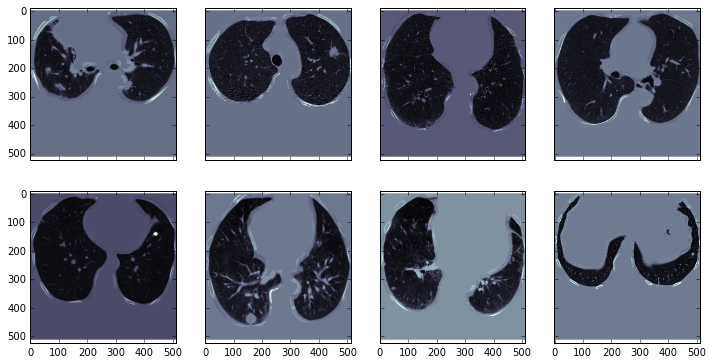

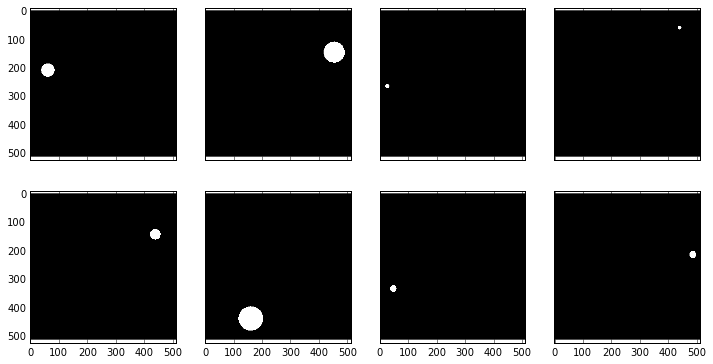

In [6]:
N_train=len(X_train)
N_test=len(X_test)

# display sample image
r,c=2,4
nb_slices=X_train.shape[0]
rnd_inds=np.random.randint(nb_slices,size=r*c)

print 'slices:', rnd_inds
f, plots = plt.subplots(r, c, sharex='all', sharey='all', figsize=(c*3, r*3))
print 'wait ...'
for i in range(r*c):
    #plots[i // c, i % c].axis('off')
    plots[i // c, i % c].imshow(X_train_r[rnd_inds[i],0], cmap=plt.cm.bone)

# display sample image
r,c=2,4
nb_slices=Y_train.shape[0]
#rnd_inds=np.random.randint(nb_slices,size=r*c)

print 'slices:', rnd_inds
f, plots = plt.subplots(r, c, sharex='all', sharey='all', figsize=(c*3, r*3))
print 'wait ...'
for i in range(r*c):
    #plots[i // c, i % c].axis('off')
    plots[i // c, i % c].imshow(Y_train_r[rnd_inds[i],0], cmap=plt.cm.bone)


In [ ]:
# training params
params_train={
        'img_rows': h,
        'img_cols': w,           
        'weights_path': None,        
        'learning_rate': 3e-4,
        'optimizer': 'Adam',
        'loss': 'dice',
        'nbepoch': 100,
        'num_labels': 2,
        'nb_filters': 64,    
        'max_patience': 20,
        }

# build the model
model = model(params_train)
model.summary()

____________________________________________________________________________________________________
Layer (type)                     Output Shape          Param #     Connected to                     
input_1 (InputLayer)             (None, 1, 512, 512)   0                                            
____________________________________________________________________________________________________
convolution2d_1 (Convolution2D)  (None, 32, 512, 512)  320         input_1[0][0]                    
____________________________________________________________________________________________________
convolution2d_2 (Convolution2D)  (None, 32, 512, 512)  9248        convolution2d_1[0][0]            
____________________________________________________________________________________________________
maxpooling2d_1 (MaxPooling2D)    (None, 32, 256, 256)  0           convolution2d_2[0][0]            
___________________________________________________________________________________________

## Training

In [ ]:
print 'training in progress ...'

# checkpoint
weightfolder='./output/weights/'+experiment
if  not os.path.exists(weightfolder):
    os.makedirs(weightfolder)
    print 'weights folder created'

# path to weights
path2weights=weightfolder+"/weights.hdf5"

# checkpoint settings
checkpoint = ModelCheckpoint(path2weights, monitor='val_loss', verbose=0, save_best_only='True',mode='min')

# load last weights
#if  os.path.exists(path2weights):
#    model.load_weights(path2weights)

# path to csv file to save scores
path2scorescsv = weightfolder+'/scores.csv'
first_row = 'train,test'
with open(path2scorescsv, 'w+') as f:
    f.write(first_row + '\n')
    
    
# Fit the model
start_time=time.time()
scores_test=[]
scores_train=[]
if params_train['loss']=='dice': 
    best_score = 0
    previous_score = 0
else:
    best_score = 1e6
    previous_score = 1e6
patience = 0

for e in range(params_train['nbepoch']):
    print 'epoch: %s,  Current Learning Rate: %s' %(e,params_train['learning_rate'])
    seed = np.random.randint(0, 999999)
    
    # augment and normalize
    #X_train_t,Y_train_t=elastic_transform_multi(X_train,Y_train,elatic_arg)
    #X_train_aug,Y1aug,tmp= utils0.standardize_augment_data(X_train_t, 255*Y_train_t, params, trainaug_params, seed)
    #Y_train_aug=add_background(Y1aug)
    # reshape for softmax output    
    #n,c,h,w=Y_train_aug.shape
    #y_train_aug=np.transpose(Y_train_aug,(0,2,3,1))        
    #y_train_aug=np.reshape(y_train_aug,(n,h*w,c))
    
    #X_test_aug,Y_test_aug,tmp= utils.standardize_augment_data(X_test, 255*Y_test, params, aug_params_test, seed)
    # reshape for softmax output    
    #n,c,h,w=Y_test_aug.shape
    #y_test_aug=np.transpose(Y_test_aug,(0,2,3,1))        
    #y_test_aug=np.reshape(y_test_aug,(n,h*w,c))

    # fit model
    #model.fit(X_train_aug, y_train_aug, validation_data=(X_test_aug, y_test_aug), nb_epoch=1, batch_size=8,verbose=0,shuffle=True,callbacks=[checkpoint])
    model.fit(X_train_r, Y_train_r, validation_data=(X_test_r, Y_test_r), nb_epoch=1, 
              batch_size=2,verbose=0,shuffle=True,callbacks=[checkpoint])
    
    # evaluate on test and train data
    #score_test=model.evaluate(X_test_aug, y_test_aug,verbose=0)
    score_test=model.evaluate(X_test_r, Y_test_r,verbose=0)
    #score_train=model.evaluate(X_train_aug, y_train_aug,verbose=0)
    score_train=model.evaluate(X_train_r, Y_train_r,verbose=0)
    if params_train['loss']=='dice': 
        score_test=score_test[1]   
        score_train=score_train[1]
    
               
    
    print 'score_train: %s, score_test: %s' %(score_train,score_test)
    scores_test=np.append(scores_test,score_test)
    scores_train=np.append(scores_train,score_train)    

    # check if there is improvement
    if params_train['loss']=='dice': 
        if (score_test>=best_score):
            print "!!!!!!!!!!!!!!!!!!!!!!!!!!! viva, improvement!!!!!!!!!!!!!!!!!!!!!!!!!!!" 
            best_score = score_test
            patience = 0
        # learning rate schedule
        if score_test<previous_score:
            #print "Incrementing Patience."
            patience += 1
    else:
        if (score_test<=best_score):
            print "!!!!!!!!!!!!!!!!!!!!!!!!!!! viva, improvement!!!!!!!!!!!!!!!!!!!!!!!!!!!" 
            best_score = score_test
            patience = 0
        # learning rate schedule
        if score_test>previous_score:
            #print "Incrementing Patience."
            patience += 1
        
    
    if patience == params_train['max_patience']:
        params_train['learning_rate'] = params_train['learning_rate']/2
        print "Upating Current Learning Rate to: ", params_train['learning_rate']
        model.optimizer.lr.set_value(params_train['learning_rate'])
        print "Loading the best weights again. best_score: ",best_score
        model.load_weights(path2weights)
        patience = 0
    
    # save current test score
    previous_score = score_test    
    
    # real time plot
    #plt.plot([e],[score_train],'b.')
    #plt.plot([e],[score_test],'b.')
    #display.clear_output(wait=True)
    #display.display(plt.gcf())
    #sys.stdout.flush()
    
    # store scores into csv file
    with open(path2scorescsv, 'a') as f:
        string = str([score_train,score_test])
        f.write(string + '\n')
       

print 'model was trained!'
elapsed_time=(time.time()-start_time)/60
print 'elapsed time: %d  mins' %elapsed_time

training in progress ...
epoch: 0,  Current Learning Rate: 0.0003


In [ ]:
plt.figure(figsize=(10,7))
plt.plot(score_test)
plt.plot(score_train)
plt.title('train-validation progress',fontsize=20)
plt.legend(('test','train'), loc = 'upper right',fontsize=20)
plt.xlabel('epochs',fontsize=20)
plt.ylabel('loss',fontsize=20)
plt.grid(True)
plt.show()

print 'best scores train: %.5f' %(np.min(score_train))
print 'best scores test: %.5f' %(np.min(score_test))

In [ ]:
# validation 
print('-'*50)
print('wait to predict ...')

# load best weights
model.load_weights(path2weights)

s_train=[]
for n1 in range(0,len(X_train),step):
    X_train_r=preprocess(X_train[n1:n1+step],param_prep)
    y_train_r=y_train[n1:n1+step]
    s_train.append(model.evaluate(X_train_r, y_train_r,verbose=0))
    
s_test=[]
for n1 in range(0,len(X_test),step):
    X_test_r=preprocess(X_test[n1:n1+step],param_prep)
    y_test_r=y_test[n1:n1+step]
    s_test.append(model.evaluate(X_test_r, y_test_r,verbose=0))

print 'loss train: %.5f, loss test: %.5f ' %(np.mean(s_train),np.mean(s_test))  

In [ ]:
print 'wait to predict ...'
X=X_test

y_pred=np.zeros_like(y_test)
for n1 in range(0,len(X_test),step):
    X_test_r=preprocess(X_test[n1:n1+step],param_prep)
    y_test_r=y_test[n1:n1+step]
    y_pred[n1:n1+step]= model.predict(X_test_r)
    
print 'predict ready!'
print 'output shape:', y_pred.shape


# accuracy
y1 = np.argmax(y_test,axis=1)
y2=np.argmax(y_pred,axis=1)
diff = y1-y2
print diff.shape

n_tot = y1.shape[0]
n_rig = (diff==0).sum()
acc = n_rig*100.0/n_tot
print "Accuracy: %0.02f pct (%d of %d) right"%(acc, n_rig, n_tot)